# Build and train the model

In [1]:
import os
import math
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def train_model(train_file, model_file):
    # write your code here. You can add functions as well.
    # use torch library to save model parameters, hyperparameters, etc. to model_file
    print('Finished...')

if __name__ == "__main__":
    # make no changes here
    train_file = sys.argv[1]
    model_file = sys.argv[2]
    train_model(train_file, model_file)


Finished...


# Load and do the inference

In [2]:
import os
import math
import sys
import torch

def tag_sentence(test_file, model_file, out_file):
    # write your code here. You can add functions as well.
		# use torch library to load model_file
    print('Finished...')

if __name__ == "__main__":
    # make no changes here
    test_file = sys.argv[1]
    model_file = sys.argv[2]
    out_file = sys.argv[3]
    tag_sentence(test_file, model_file, out_file)


IndexError: list index out of range

# The network:
1. CNN character level word embedder
1. concatenate CNN embedding with word embedding
1. bi-directional LSTM block, looking at a sentence
1. fully conncected layer? (what does linear projection mean?)

In [20]:
!pip install fastprogress matplotlib
from fastprogress import progress_bar
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

training_data = Path("../data/sents.train")

# Creating data input pipeline

In [4]:
import torch
import torch.utils.data


class Dataset(torch.utils.data.Dataset):
    """
    
    """
    def __init__(self, path, to_lower=True):
        self.to_lower = to_lower
        self.sentences = []
        self.vocab = []
        self.tags = []
        
        self.generate_dataset(path)
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        sentence_embs, tag_embs = self.transform_sentence(self.sentences[index])
        return sentence_embs, tag_embs
    
    def generate_dataset(self, path):
        with open(path, 'r') as input_file:
            self.sentences = input_file.read().split("\n")
            self.create_vocabs(self.sentences)
            
            self.vocab_size = len(self.vocab)
            self.tag_size = len(self.tags)
            
            if self.sentences[-1] == "":
                self.sentences.pop()
            
    
    def create_vocabs(self, sentences):
        vocab_set = set()
        tag_set = set()

        for sentence in sentences:
            for word in sentence.split(" "):
                try:
                    word, tag = self.split_words_tag(word)
                    vocab_set.add(word.lower() if self.to_lower else word)
                    tag_set.add(tag)
                except RuntimeError:
                    print("Not a valid word/tag pair: " + word)

        self.vocab = list(vocab_set)
        self.tags = list(tag_set)
            
    def transform_sentence(self, sentence):
        numeric_sent = []
        tags = []

        for word_tag in sentence.split(" "):
            try:
                word, tag = self.split_words_tag(word_tag)
                tag_id = self.tags.index(tag)
                word_id = self.vocab.index(word.lower() if self.to_lower else word)

            except RuntimeError:
                print("Not a valid word/tag pair: " + word_tag)
            except ValueError:
                print("Word not in the vocab: " + word_tag)
                # The id of an unknown word
                word_id = len(self.vocab)
                tag_id = len(self.tags)

            numeric_sent.append(word_id)
            tags.append(tag_id)

        return torch.tensor(numeric_sent), torch.tensor(tags)

    @staticmethod
    def split_words_tag(word):
        words_tag = word.split("/")
        
        if len(words_tag) < 2: 
            raise RuntimeError("Not a valid word/tag pair:" + word)
            
        tag = words_tag.pop()
        word = "/".join(words_tag)
        
        return word, tag
                
    def decode_sentence(self, sentence):
        return " ".join([self.vocab[word.item()] for word in sentence.view(-1)])


In [5]:
%%time
dataset = Dataset(training_data)

Not a valid word/tag pair: 
CPU times: user 1.47 s, sys: 31.7 ms, total: 1.5 s
Wall time: 1.51 s


## DataLoader implementation

In [6]:
from torch.utils.data import DataLoader

batch_size = 1
num_workers = 4


pos_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

# Initial simple model implementation 

## Proposed plan:
1. Begin with word-level LSTM (check for an example in forum)
2. Make it bi-directional
3. Add character-level CNN

Try a new notebook: https://polynote.org/docs/01-installation.html

In [7]:
class PipelineTestModel(nn.Module):
    def __init__(self, vocab_size, emb_dims, output_dims):
        super(PipelineTestModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.emb_dims = emb_dims
        self.output_dims = output_dims
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_dims)
        self.fc = nn.LSTM(self.emb_dims, self.output_dims)
        
    def forward(self, sentence):
        print(sentence.shape)
        emb = self.emb(sentence)
        print(emb.shape)
#         tags = F.softmax(self.fc(emb), dim=self.output_dims)
        tags = self.fc(emb.view(len(sentence), 1, -1))
        print(tags.shape)
        return tags    
    
    
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence[-1]), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence[-1]), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


In [8]:
embedding_dims = 128
hidden_dims = 64
vocab_size = dataset.vocab_size
tagset_size = dataset.tag_size

model = LSTMTagger(embedding_dims, hidden_dims, vocab_size, tagset_size)

In [9]:
pos_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

In [10]:
class TestEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden, out_dims):
        super(TestEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden = hidden
        self.out_dims = out_dims
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size)
        self.lstm = nn.LSTM(self.emb_size, self.hidden)
        self.fc = nn.Linear(self.hidden, self.out_dims)
        
    def forward(self, sentence):
        embeddings = self.emb(sentence)
        hidden, _ = self.lstm(embeddings)
#         return hidden.view(len(sentence[-1]), 1, -1)
        return self.fc(hidden.view(len(sentence[-1]), 1, -1)).view(1, len(sentence[-1]), -1)
    
test_model = TestEmbedding(dataset.vocab_size, 128, 10, dataset.tag_size)
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


x, y = next(iter(pos_dataloader))

pred = test_model(x)
test_model.zero_grad()

print(pred.shape, " ", y.shape)

loss = loss_func(pred, y.view(-1))


# y1, (y2, y3) = test_model(x)
# print(y1.shape)
# print(y2.shape)
# print(y3.shape)

torch.Size([1, 49, 45])   torch.Size([1, 49])


ValueError: Expected input batch_size (1) to match target batch_size (49).

In [11]:
loss

NameError: name 'loss' is not defined

## Pad the input so that it is possible to use mini-batches

- Padding | https://discuss.pytorch.org/t/understanding-pack-padded-sequence-and-pad-packed-sequence/4099
- Padding | https://discuss.pytorch.org/t/simple-working-example-how-to-use-packing-for-variable-length-sequence-inputs-for-rnn/2120

## The padding needs to take place in the DataLoader
- Most likely will need to use sampler & collate_fn


In [30]:
%%time

gpu = torch.device("cuda")

model = LSTMTagger(embedding_dims, hidden_dims, vocab_size, tagset_size)
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 1

tag_size = dataset.tag_size
losses = []

i = 0

model.to(gpu)

for epoch in progress_bar(range(epochs)):
    for x, y in pos_dataloader:
        model.zero_grad()
        
        x, y = x.to(gpu), y.to(gpu)

        pred = model(x)
        loss = loss_func(pred.view(-1, tag_size), y.view(-1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        

CPU times: user 2min 55s, sys: 18.6 s, total: 3min 14s
Wall time: 5min 28s


4.1484832763671875e-05


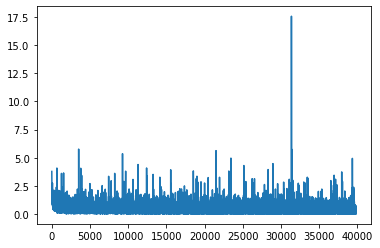

In [32]:
plt.plot(losses)
print(min(losses))

In [90]:
gpu = torch.device("cuda")
# gpu_model = model.to(gpu)


stop_range = 1
i = 0
epochs = 1

preds = []

for epoch in range(epochs):
    for x, y in progress_bar(pos_dataloader):
        if i > stop_range: break
        i += 1
        
#         x_gpu, y_gpu = x.to(gpu), y.to(gpu)
#         preds.append(model(x))
        

In [94]:
[pred.max(0)[1] for pred in preds]

[tensor([31, 41, 46, 18, 18, 11, 22, 24, 21, 43, 18, 23, 33, 32, 42, 41,  6, 10,
         10, 26,  1, 21, 13, 10, 42, 19, 42, 28, 24, 35, 28, 46, 37, 32,  5, 16,
         48, 13, 35, 42, 29, 43, 28,  5, 23]),
 tensor([0, 0, 4, 0, 2, 2, 4, 1, 0, 4, 0, 3, 4, 1, 0, 0, 3, 4, 0, 2, 1, 4, 1, 4,
         3, 2, 1, 3, 1, 2, 2, 3, 0, 2, 1, 4, 1, 4, 4, 1, 0, 4, 0, 3, 3]),
 tensor([ 8, 19, 15,  0,  2,  9,  9, 15, 13, 19,  4,  3,  0, 14, 13, 15,  7,  9,
          6,  8,  5,  1,  6, 13,  9,  0,  1,  6,  1, 14, 11, 15, 18,  2, 13,  6,
          2, 10, 19,  1, 14, 15,  9,  6,  4]),
 tensor([ 4,  7,  1,  5, 10,  7, 10,  2,  1,  7,  3,  9, 10,  2,  6,  9,  2,  3,
          6, 11,  2, 11,  1,  1,  6,  5,  2,  2,  2,  0,  7,  2,  6, 10,  2, 10,
          8, 10,  2,  8,  6,  5,  4,  6,  5]),
 tensor([10,  7, 15, 27, 24, 12,  1,  8, 15, 28, 13, 13, 23, 16,  7, 22, 16, 10,
          6, 13, 25, 14, 11, 15, 12, 11, 27,  1, 25, 21, 21, 16,  7,  1,  5, 11,
         28, 18, 28, 20, 10, 12, 26, 26,  9]),
 tensor([

In [114]:
for i in progress_bar(range(1000000000)):
    i = 10

KeyboardInterrupt: 

In [3]:
!nvidia-smi

Mon Oct 28 09:58:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P5    12W / 180W |   1436MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
import torch
torch.rand(1).to(torch.device("cuda"))

tensor([0.7433], device='cuda:0')